In [1]:
from pandas import Series
import pandas as pd
import numpy as np
# import pandas_profiling
# from dataprep.eda import plot, plot_correlation, create_report, plot_missing
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler,RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

print(f'Размерность тренировочного датасета: {train.shape}')
print(f'Размерность тестового датасета: {test.shape}')

Размерность тренировочного датасета: (73799, 19)
Размерность тестового датасета: (36349, 18)


In [3]:
# conda install -c conda-forge pandas-profiling

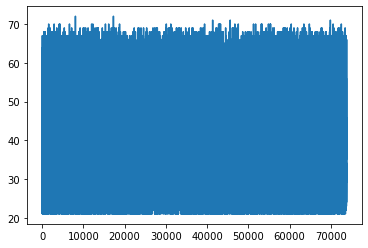

In [4]:
train.age.plot()

In [5]:
train[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0


In [6]:
test[:4]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N


In [7]:
sub[:4]

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501


### Проверим, пересекаются ли данные в тренировочном и тестовом датасетах


In [8]:
set(test.client_id) & set(set(train.client_id))

set()

##### (Не пересекаются)

### Объединяем таблицы с добавлением параметра-указателя принадлежности к тестовой выборке

In [9]:
train['test'] = 0
test['test'] =1
df = pd.concat([train,test],axis=0)

In [10]:
print(df[df['test']==0].shape)
print(df[df['test']==1].shape)


(73799, 20)
(36349, 20)


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 36348
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        110

Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту


####  Вывод: в тренировочной выборке   73799 записей, в тестовой 36349 записей. Имется небольшое количество пропусков в признаке education (0.43% суммарно), которые мы заполним. Данные в тренировочной и тестовой выборках не пересекаются 

In [12]:
df[:3]

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,test
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,0


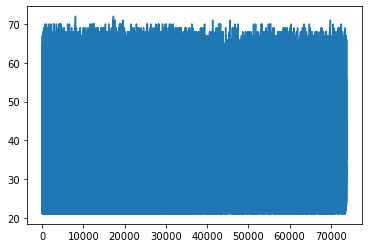

In [13]:
df['age'].plot()

In [14]:
edu_name = df['education'].value_counts().index.to_list() # Получаем список значений
edu_distr = df['education'].value_counts(normalize=True).values # Получаем список вероятностей
missing = df['education'].isnull() # Флаги с наличием пропусков
df.loc[missing, ['education']] = np.random.choice(
    edu_name, size=len(df[missing]), p=edu_distr) # Подставляем значения из списка имен в соответствии в вероятностью встречи имени

# 1.Анализ данных

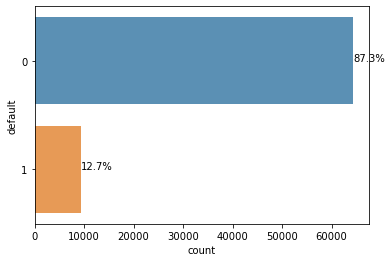

In [15]:
ax = sns.countplot(y='default', data= train, alpha=0.8)
total = train.shape[0]

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    x = p.get_x() + p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage,(x,y))
plt.show()


client_id        |110148     |int64 
app_date         |120        |object 
education        |5          |object 
sex              |2          |object 
age              |52         |int64 
car              |2          |object 
car_type         |2          |object 
decline_app_cnt  |24         |int64 
good_work        |2          |int64 
score_bki        |102618     |float64 
bki_request_cnt  |40         |int64 
region_rating    |7          |int64 
home_address     |3          |int64 
work_address     |3          |int64 
income           |1207       |int64 
sna              |4          |int64 
first_time       |4          |int64 
foreign_passport |2          |object 
default          |2          |float64 
test             |2          |int64 


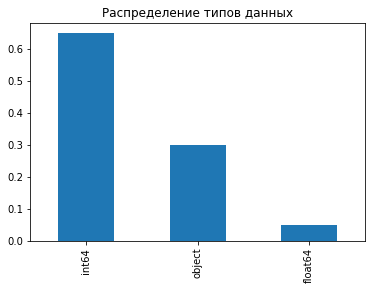

In [16]:
for i in df.columns:
    print('{0:<16} |{1:<10} |{2} '.format(i, df[i].nunique(), df[i].dtypes))
    train.dtypes.value_counts(normalize=True).plot(
        kind='bar', title='Распределение типов данных')

In [17]:
bin_ = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
num_ = ['age',  'income', 'score_bki']
cat_ = ['decline_app_cnt', 'bki_request_cnt', 'education',
        'work_address', 'home_address', 'sna', 'region_rating', 'first_time']

In [18]:
df_num = df.drop(bin_+cat_, axis=1).drop(['client_id', 'app_date', ], axis=1)
df_cat = df.drop(num_+bin_, axis=1).drop(['client_id', 'app_date', ], axis=1)
df_bin = df.drop(num_+cat_, axis=1).drop(['client_id', 'app_date', ], axis=1)

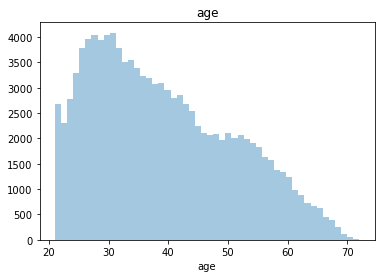

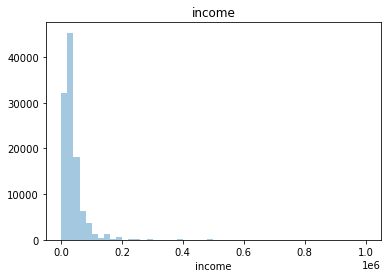

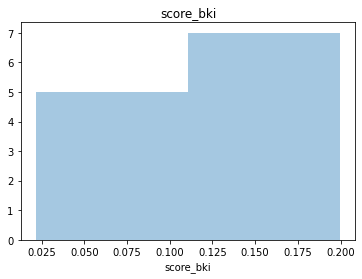

In [19]:
for i in num_:
    plt.figure()
    sns.distplot(df[i][df[i] > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

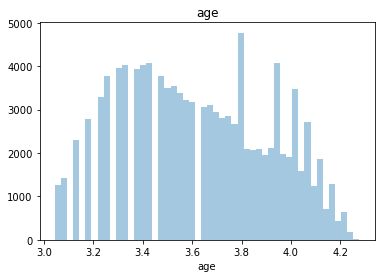

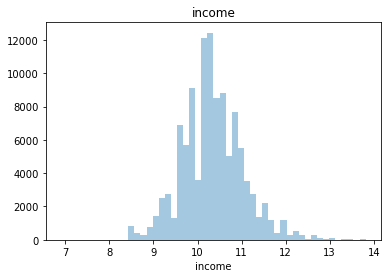

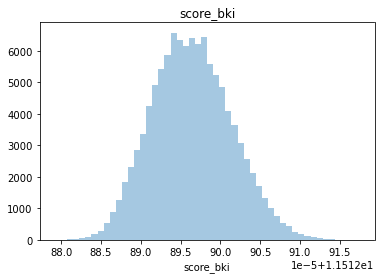

In [20]:
for_log_plot = df_num.copy()
for_log_plot['score_bki'] = for_log_plot['score_bki']+99999
for i in num_:
    plt.figure()
    sns.distplot(np.log(for_log_plot[i])[np.log(
        for_log_plot[i]) > 0].dropna(), kde=False, rug=False)
    plt.title(i)
    plt.show()

In [21]:
# pandas_profiling.ProfileReport(df.drop(['client_id','default','test'],axis=1))

<ipython-input-22-3569fe8fa575>:1: RuntimeWarning: invalid value encountered in log
  sns.heatmap(np.log(df[num_]).corr().abs(), vmin=0, vmax=1)
<ipython-input-22-3569fe8fa575>:2: RuntimeWarning: invalid value encountered in log
  display(np.log(df[num_]).corr().abs())


,age,income,score_bki
age,1.000000,0.090011,0.345474
income,0.090011,1.000000,0.480222
score_bki,0.345474,0.480222,1.000000


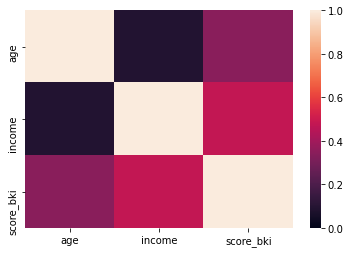

In [22]:
sns.heatmap(np.log(df[num_]).corr().abs(), vmin=0, vmax=1)
display(np.log(df[num_]).corr().abs())

In [23]:
train.drop(bin_+cat_, axis=1).drop(['client_id', 'app_date', 'test'], axis=1)

,age,score_bki,income,default
0,62,-2.008753,18000,0
1,59,-1.532276,19000,0
2,25,-1.408142,30000,0
3,53,-2.057471,10000,0
4,48,-1.244723,30000,0
...,...,...,...,...
73794,45,-1.792064,17000,0
73795,41,-2.058029,70000,0
73796,31,-1.512635,45000,0
73797,29,-1.479334,13000,1


In [24]:
label_encoder = LabelEncoder()

for column in bin_:
    df_bin[column] = label_encoder.fit_transform(df_bin[bin_][column])

# убедимся в преобразовании
df_bin[bin_].head()

,sex,car,car_type,foreign_passport,good_work
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,1,0
3,0,0,0,0,0
4,1,0,0,1,1


In [61]:
git clone git://github.com/pydata/pandas.git
cd pandas
python setup.py install

SyntaxError: invalid syntax (<ipython-input-61-501fc2b128a0>, line 1)

In [66]:
conda install pandas==1.2.3

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Vetak8\anaconda3

  added / updated specs:
    - pandas==1.2.3


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    pandas-1.2.3               |   py38hf11a4ad_0         7.9 MB
    ------------------------------------------------------------
                                           Total:         7.9 MB

The following NEW packages will be INSTALLED:

  pandas             pkgs/main/win-64::pandas-1.2.3-py38hf11a4ad_0




pandas-1.2.3         | 7.9 MB    |            |   0% 
pandas-1.2.3         | 7.9 MB    |            |   0% 
pandas-1.2.3         | 7.9 MB    | 4          |   5% 
pandas-1.2.3         | 7.9 MB    | #3         |  13% 
pandas-1.2.3         | 7.9 MB    | ##3        |  23% 
pandas-1.2.3         | 7.9 MB    | ##7        |  28% 
pandas-1.2.3         | 7.9 MB    | ###2       |  33% 
panda

In [65]:
print(pd.__version__)

1.0.5


In [53]:
df[['sex','age']].value_counts()

AttributeError: 'DataFrame' object has no attribute 'value_counts'

In [25]:
df_cat['education'] = label_encoder.fit_transform(df_cat['education'])

In [26]:
label_encoder = LabelEncoder()

for column in cat_:
    df_cat[column] = label_encoder.fit_transform(df_cat[cat_][column])

# убедимся в преобразовании
df_cat[cat_].head()

,decline_app_cnt,bki_request_cnt,education,work_address,home_address,sna,region_rating,first_time
0,0,1,3,1,0,3,3,0
1,0,3,3,2,1,3,3,0
2,2,1,3,1,0,0,6,3
3,0,2,3,2,1,0,3,2
4,0,1,1,2,1,0,4,3


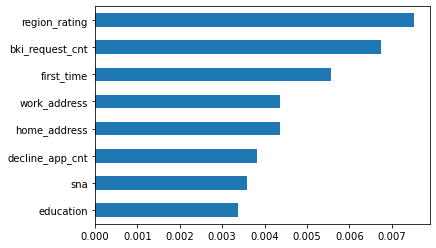

In [42]:
imp_cat = Series(mutual_info_classif(df_cat[df_cat['test'] == 0].drop(['test', 'default'], axis=1), df_cat['default'][df['test'] == 0],
                                     discrete_features=True), index=cat_)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

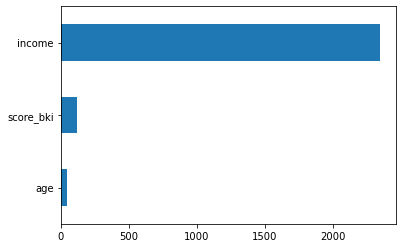

In [28]:
imp_num = Series(f_classif(df_num[df_num['test'] == 0].drop(
    ['default', 'test'], axis=1), df_num['default'][df_num['test'] == 0])[0], index=num_)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

In [29]:
df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1)

,age,score_bki,income
0,29,-2.271884,50000
1,39,-1.504999,5000
2,50,-1.691339,30000
3,56,-2.374182,17000
4,38,-2.487502,120000
...,...,...,...
36344,37,-1.744976,15000
36345,64,-2.293781,200000
36346,31,-0.940752,60000
36347,27,-1.242392,30000


In [30]:
# X_num_train = RobustScaler().fit_transform(
#     df_num[df_num['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_cat_train = OneHotEncoder(sparse=False).fit_transform(
#     df_cat[df_cat['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_bin_train = OneHotEncoder(sparse=False).fit_transform(
#     df_bin[df_bin['test'] == 0].drop(['test', 'default'], axis=1).values)
# X_num_test = RobustScaler().transform(
#     df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1).values)
# X_cat_test = OneHotEncoder(sparse=False).fit(
#     df_cat[df_cat['test'] == 1].drop(['test', 'default'], axis=1).values)
# X_bin_test = OneHotEncoder(sparse=False).fit(
#     df_bin[df_bin['test'] == 1].drop(['test', 'default'], axis=1).values)

In [31]:
scaler = RobustScaler()
X_num_train = scaler.fit_transform(
    df_num[df_num['test'] == 0].drop(['test', 'default'], axis=1).values)
X_num_test = scaler.transform(
    df_num[df_num['test'] == 1].drop(['test', 'default'], axis=1).values)

X_cat_train = df_cat[cat_][df['test'] == 0]
X_cat_test = df_cat[cat_][df['test'] == 1]

X_bin_train = df_bin[bin_][df['test']==0]
X_bin_test = df_bin[bin_][df['test']==1]

In [32]:
X_bin_train.shape

(73799, 5)

In [33]:
X_train = np.hstack([X_num_train, X_cat_train, X_bin_train])
y_train = df['default'][df['test'] == 0].values
X_test = np.hstack([X_num_test, X_cat_test, X_bin_test])


In [34]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=50)

In [35]:
model = LogisticRegression()
model.fit(X_train,y_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba = y_pred_proba[:,1]
y_pred = model.predict(X_test)
# model.fit(X, y)
# y_pred_proba = model.predict_proba(X_sub)
# y_pred = model.predict(X_sub)

In [36]:
len(y_pred_proba)

36349

In [37]:
id_test = df['client_id'][df['test']==1]

In [38]:
type(y_pred_proba)

numpy.ndarray

In [39]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': y_pred_proba})
my_submission.to_csv('submission.csv', index=False)

In [40]:
my_submission

,client_id,default
0,74835,0.044844
1,17527,0.299950
2,75683,0.081134
3,26883,0.081234
4,28862,0.026701
...,...,...
36344,83775,0.307175
36345,106254,0.021503
36346,81852,0.337321
36347,1971,0.194224


In [41]:
# plt.figure(figsize=[15, 20])
# i = 1

# y, hue = 'proportion', 'default'

# for k in bin_+cat_:
#     plt.subplot(5, 2, i)
#     sns.barplot(x='sex', y='proportion', hue='default',  data=df[df['test'] == 0][[
#                 k, 'default']].value_counts(normalize=True).rename('proportion').reset_index())
#     plt.title('Categorical Feature Name\n' + i, fontsize=15)
#     plt.xlabel(i)
#     plt.ylabel('Quantity (frequency)')
#     ax.tick_params(direction='out', length=0, width=5, colors='grey')

#     plt.show()